## EDA and Report Generation

### Vegas Accuracy
Here we will look at Vegas bookmakers historical performance predicting the NFL games.

In [90]:
import pandas as pd
from pathlib import Path
from src.config import INTERIM_DATA_DIR, RAW_DATA_DIR
from sklearn.model_selection import train_test_split
import re

train_path: Path = INTERIM_DATA_DIR / "trainset.csv"
base_path: Path = INTERIM_DATA_DIR / "base.csv"

df_base = pd.read_csv(str(base_path))
df_base.head()

,id,season,event_date,tm_nano,tm_market,tm_name,tm_alias,opp_nano,opp_market,opp_name,...,opp_rush_tds,opp_rush_yds,opp_third_down_att,opp_third_down_conv,opp_third_down_conv_pct,opp_time_of_possession,opp_times_sacked,opp_total_yds,opp_turnovers,opp_yds_sacked_for
0,200009030min,2000,2000-09-03,AzOs5UWsXusSW,Minnesota,Vikings,MIN,1vVmWGzUZ1rea,Chicago,Bears,...,1,153,15,9,0.600,1954,2,425,1,18
1,200009030kan,2000,2000-09-03,oiGiwWPf0UqMC,Kansas City,Chiefs,KC,LJmHetie5VbbO,Indianapolis,Colts,...,1,119,13,6,0.462,1993,1,386,2,6
2,200009030was,2000,2000-09-03,9JtBk8kFeaGEs,Washington,Football Team,WAS,jJBGuksuDJF5L,Carolina,Panthers,...,0,112,11,2,0.182,1606,6,236,1,59
3,200009030atl,2000,2000-09-03,mLspw4gJNTQGN,Atlanta,Falcons,ATL,IwSI92ZDKoazn,San Francisco,49ers,...,1,92,9,2,0.222,1701,1,339,1,6
4,200009030cle,2000,2000-09-03,IR4gIYmh269EI,Cleveland,Browns,CLE,RtOjnciWkJPaL,Jacksonville,Jaguars,...,2,119,16,10,0.625,2223,4,398,0,22


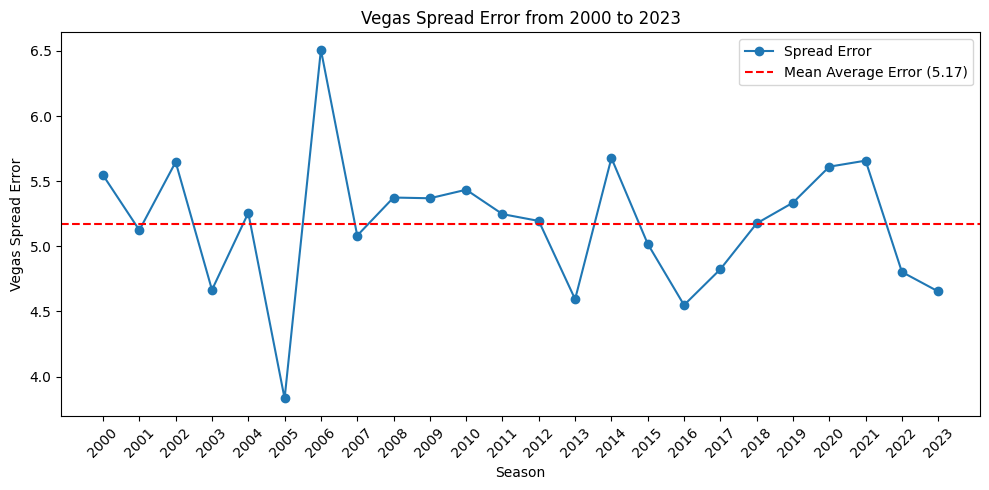

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from src.config import FIGURES_DIR

#error scenarios 
#if tm_spread -ve and r_spread > tm_spread
#if tm_spread +ve and  r_spread < tm_spread
def calc_vegas_error(r: pd.Series):
    r_spread = r.loc['tm_score'] - r.loc['opp_score']
    tm_spread = r.loc['tm_spread']
    if tm_spread <= 0.:
        r['vegas_error'] = max(0, abs(tm_spread) - r_spread)
    else:
        r['vegas_error'] = max(0, tm_spread + r_spread)
    return r

df_base = df_base.apply(calc_vegas_error, axis=1)
df_vegas_avg = df_base.loc[:, ['season','vegas_error']].set_index('season')
vegas_avg_err = []
for season in range(2000, 2024):
    vegas_avg_err.append(df_vegas_avg.loc[season, 'vegas_error'].mean())

overall_avg = np.mean(vegas_avg_err)
# Plot the spread error for each season
seasons = range(2000, 2024)
plt.figure(figsize=(10,5))
plt.plot(seasons, vegas_avg_err, marker='o', label='Spread Error')

# Plot the overall average line
plt.axhline(y=overall_avg, color='r', linestyle='--', label=f'Mean Average Error ({overall_avg:.2f})')

# Customize the x-axis to display every season
plt.xticks(seasons, rotation = 45)  # Rotating labels for better readability

plt.xlabel('Season')
plt.ylabel('Vegas Spread Error')
plt.title('Vegas Spread Error from 2000 to 2023')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent label overlap
fig_path = FIGURES_DIR / "vegas_spread_error.png"
plt.savefig(str(fig_path))
plt.show()


## Simulating Bets

In [24]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from src.config import PROCESSED_DATA_DIR, INTERIM_DATA_DIR


int_test_path : Path = INTERIM_DATA_DIR / "testset.csv"
scaled_test_path: Path = PROCESSED_DATA_DIR / "scaled" /"testset.csv"
unscaled_test_path: Path = PROCESSED_DATA_DIR / "unscaled" /"testset.csv"

df_test = pd.read_csv(str(scaled_test_path), index_col='id')
df_int = pd.read_csv(str(int_test_path), index_col='id')

In [18]:
from src.modeling.predict import predict_gbt

rfr_results = predict_gbt(df_test.drop(columns=['r_spread']))
def calc_rspread(tm_score, opp_score):
    return tm_score - opp_score
r_spread_list = [calc_rspread(row[0], row[1]) for row in df_int[['tm_score', 'opp_score']].to_numpy()]
df_pred = pd.DataFrame({'r_spread': r_spread_list, 'pred': rfr_results.flatten().tolist(), 'spread_line': df_int['tm_spread'].values.tolist()})

In [25]:
from src.modeling.predict import predict_support_vectors

svr_results = predict_support_vectors(df_test.drop(columns=['r_spread']))
#using unscaled spread values
scaler_path = MODELS_DIR / "scalers" / "scaler_y.gz"
scaler_y = joblib.load(scaler_path)
svr_results = scaler_y.inverse_transform(svr_results.reshape(-1, 1))
def calc_rspread(tm_score, opp_score):
    return tm_score - opp_score
r_spread_list = [calc_rspread(row[0], row[1]) for row in df_int[['tm_score', 'opp_score']].to_numpy()]
df_pred = pd.DataFrame({'r_spread': r_spread_list, 'pred': svr_results.flatten().tolist(), 'spread_line': df_int['tm_spread'].values.tolist()})

Total Wagered: 33880
Total PnL: 2030


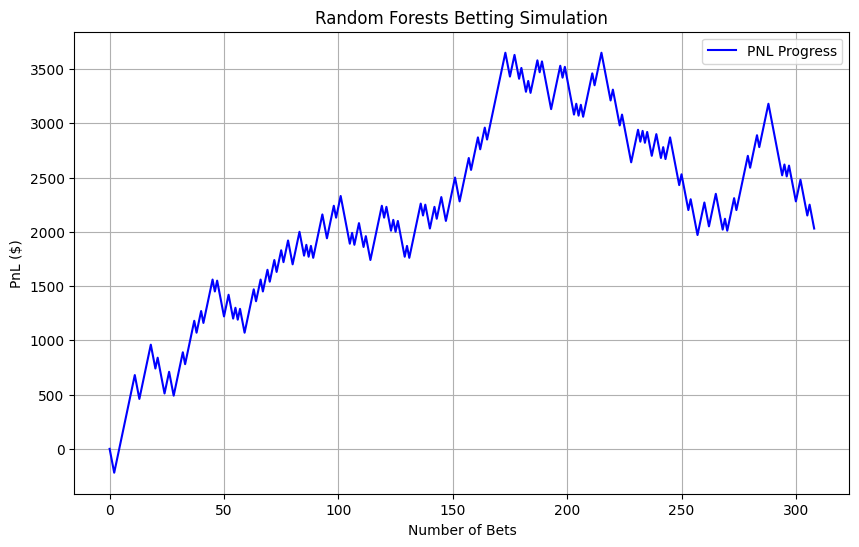

In [26]:
# Initialize variables for pnl and profit/loss
current_pnl = 0
wager_amount = 110  # Wager $110 per bet to win $100
total_wagered = 0

# Initialize a list to store pnl after each bet
pnl_progress = []

# Loop through each row to simulate the bets
for index, row in df_pred.iterrows():
    actual_r_spread = row['r_spread']
    prediction = row['pred']
    spread_line = row['spread_line']
    
    # Betting strategy: Bet on the team if pred > spread_line (predicting the team will cover the spread)
    if spread_line < 0 and (prediction - abs(spread_line)) > 1:
        # If actual r_spread (team's win margin) covers the spread line, bet wins
        total_wagered+=wager_amount
        if actual_r_spread > abs(spread_line):
            current_pnl += 100  # Win $100
        else:
            current_pnl -= wager_amount  # Lose $110 due to vigorish (110)
    elif spread_line > 0 and (abs(prediction) - spread_line) > 1:
        # If actual r_spread (team's win margin) covers the spread line, bet wins
        total_wagered+=wager_amount
        if abs(actual_r_spread) > spread_line:
            current_pnl += 100  # Win $100
        else:
            current_pnl -= wager_amount  # Lose $110 due to vigorish (110)

    # Append the current pnl to the list for tracking progress
    pnl_progress.append(current_pnl)

# Add the pnl progress to the DataFrame for visualization
df_pred['pnl'] = pnl_progress
squeezed_pnl = df_pred['pnl'].loc[df_pred['pnl'].shift() != df_pred['pnl']].reset_index(drop=True)

print(f"Total Wagered: {total_wagered}")
print(f"Total PnL: {current_pnl}")
# Plot the pnl progression over time (as bets progress)
plt.figure(figsize=(10, 6))
plt.plot(squeezed_pnl, label='PNL Progress', color='b')
plt.title('Random Forests Betting Simulation')
plt.xlabel('Number of Bets')
plt.ylabel('PnL ($)')
plt.legend()
plt.grid(True)
plt.show()




## Neural Net Simulation

In [27]:
from src.config import PROCESSED_DATA_DIR
import torch
import matplotlib.pyplot as plt
from src.config import PROCESSED_DATA_DIR, INTERIM_DATA_DIR, MODELS_DIR
from src.modeling.nn import neuralnets
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

scaled_train_path: Path = PROCESSED_DATA_DIR / "scaled" / "trainset.csv"
scaled_test_path: Path = PROCESSED_DATA_DIR / "scaled" /"testset.csv"
int_test_path : Path = INTERIM_DATA_DIR / "testset.csv"

df_train = pd.read_csv(str(scaled_train_path), index_col='id')
df_test = pd.read_csv(str(scaled_test_path), index_col= 'id')
df_int = pd.read_csv(str(int_test_path), index_col='id')

X_train, y_train = df_train.drop(columns=['r_spread']).values, df_train.loc[:,'r_spread'].values
X_test, y_test = df_test.drop(columns=['r_spread']).values, df_test.loc[:,'r_spread'].values

X_train = torch.tensor(X_train, dtype=torch.float32).to(device=device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device=device)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device=device)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32).to(device=device)

nn_path = MODELS_DIR / "neural_net.pt"
input_dim = X_train.shape[1]
model = neuralnets.NFLPredictor(input_dim).to(device=device)
model.load_state_dict(torch.load(str(nn_path), weights_only=True))
model.eval()
results = None
with torch.no_grad():
    results = model(X_test).cpu()
#using unscaled spread values
scaler_path = MODELS_DIR / "scalers" / "scaler_y.gz"
scaler_y = joblib.load(scaler_path)
results = scaler_y.inverse_transform(results.reshape(-1, 1))

def calc_rspread(tm_score, opp_score):
    return tm_score - opp_score

r_spread_list = [calc_rspread(row[0], row[1]) for row in df_int[['tm_score', 'opp_score']].to_numpy()]

df_pred = pd.DataFrame({'r_spread': r_spread_list, 'pred': results.flatten().tolist(), 'spread_line': df_int['tm_spread'].values.tolist()})

Using device: cuda


In [28]:
criterion = torch.nn.L1Loss()

with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = criterion(test_predictions, y_test)
    print(f'Test Loss (MAE): {test_loss.item():.4f}')

Test Loss (MAE): 0.8077


Total Games: 1289
Total Bets: 366
Total Wagered: 40260
Total PnL: -7710
Bets Won: 155
Win Rate: 42.349726775956285
Return on Investment (ROI): -19.150521609538004


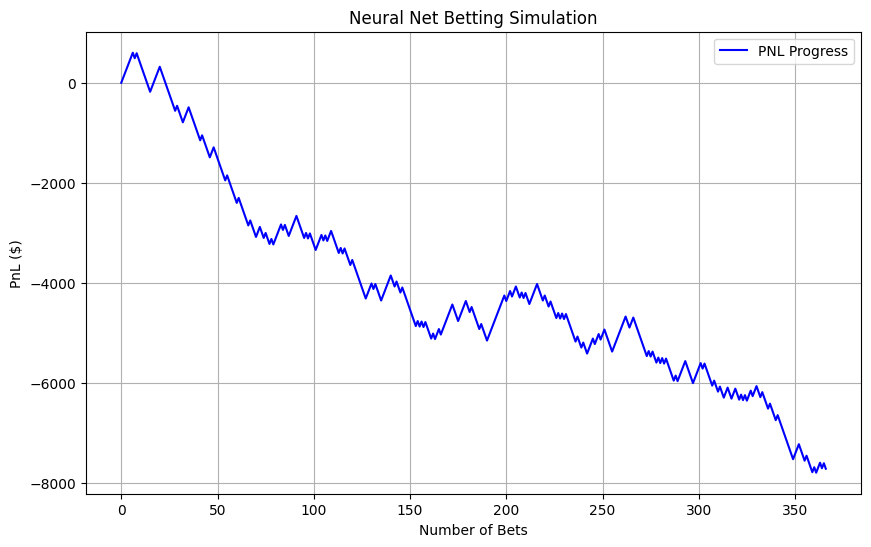

In [54]:
# Initialize variables for pnl and profit/loss
current_pnl = 0
wager_amount = 110  # Wager $110 per bet to win $100
total_wagered = 0
bets_won = 0
total_games = df_pred.shape[0]
# Initialize a list to store pnl after each bet
pnl_progress = []

# Loop through each row to simulate the bets
for index, row in df_pred.iterrows():
    actual_r_spread = row['r_spread']
    prediction = row['pred']
    spread_line = row['spread_line']
    
    # Betting strategy: Bet on the team if pred > spread_line (predicting the team will cover the spread)
    if spread_line < 0 and (prediction - abs(spread_line)) > 3:
        # If actual r_spread (team's win margin) covers the spread line, bet wins
        total_wagered+=wager_amount
        if actual_r_spread > abs(spread_line):
            current_pnl += 100  # Win $100
            bets_won+=1
        else:
            current_pnl -= wager_amount  # Lose $110 due to vigorish (110)
    if spread_line > 0 and (abs(prediction) - spread_line) > 3:
        # If actual r_spread (team's win margin) covers the spread line, bet wins
        total_wagered+=wager_amount
        if actual_r_spread > -spread_line:
            current_pnl += 100  # Win $100
            bets_won+=1
        else:
            current_pnl -= wager_amount  # Lose $110 due to vigorish (110)

    # Append the current pnl to the list for tracking progress
    pnl_progress.append(current_pnl)

# Add the pnl progress to the DataFrame for visualization
df_pred['pnl'] = pnl_progress
squeezed_pnl = df_pred['pnl'].loc[df_pred['pnl'].shift() != df_pred['pnl']].reset_index(drop=True)

print(f'Total Games: {total_games}')
print(f'Total Bets: {round(total_wagered/110)}')
print(f"Total Wagered: {total_wagered}")
print(f"Total PnL: {current_pnl}")
print(f'Bets Won: {bets_won}')
print(f'Win Rate: {(bets_won/(total_wagered/110))*100}')
print(f'Return on Investment (ROI): {(current_pnl/(total_wagered))*100}')


# Plot the pnl progression over time (as bets progress)
plt.figure(figsize=(10, 6))
plt.plot(squeezed_pnl, label='PNL Progress', color='b')
plt.title('Neural Net Betting Simulation')
plt.xlabel('Number of Bets')
plt.ylabel('PnL ($)')
plt.legend()
plt.grid(True)
plt.show()


